In [1]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from collections import defaultdict
import copy
import random
import datetime
import os
import sys
import shutil
from urllib.request import urlretrieve
import collections
import math
import time
import logging
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt


cudnn.benchmark = True
model_save_name ='exp10' #to be able to differenciate between every experiment

In [3]:
#split training and validation
root_directory = "/content/drive/MyDrive/dataset"

fields_directory = os.path.join(root_directory, "fields")
roads_directory = os.path.join(root_directory, "roads")

fields_images_filepaths = sorted([os.path.join(fields_directory, f) for f in os.listdir(fields_directory)])
roads_images_filepaths = sorted([os.path.join(roads_directory, f) for f in os.listdir(roads_directory)])
images_filepaths = [*fields_images_filepaths, *roads_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:137]
val_images_filepaths = correct_images_filepaths[137:153]

print(len(train_images_filepaths), len(val_images_filepaths))

137 16


In [4]:
class FieldsVsRoadsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "fields":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [5]:
#data augmentation 
train_transform = A.Compose(
    [
        A.Resize(250,300),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=250, width=250),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = FieldsVsRoadsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [6]:
val_transform = A.Compose(
    [
        A.Resize(250,300),
        A.CenterCrop(height=250, width=250),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = FieldsVsRoadsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [7]:
#visualize image after applying augmentation
def visualize_augmentations(dataset, idx=15, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

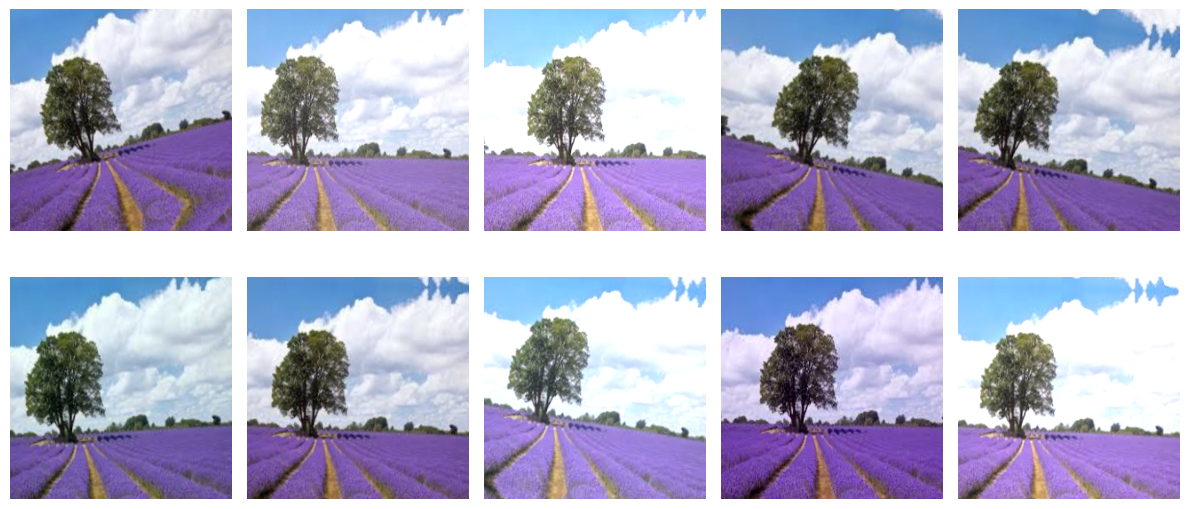

In [8]:
random.seed(24)
visualize_augmentations(train_dataset)

In [9]:
#classification using sigmoid as transfer function 
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [10]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [11]:
#different params for the model
params = {
    "model": "resnet18",
    "device": torch.device("cuda" if (torch.cuda.is_available()) else "cpu"),
    "lr": 0.001,
    "batch_size": 10,
    "epochs": 50,
}

In [12]:
#exclude the last layer of the pretrained model (classifier) and replace it with another classifier to be trained according to our data
model_initial = getattr(models, params["model"])(pretrained=True)
model = nn.Sequential(*list(model_initial.children())[:-1])
model = model.to(params["device"])
num_classes=1
fc_in_features = model_initial.fc.in_features
print(fc_in_features)
classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(fc_in_features, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        ).to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"]) #used function is sigmoid
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 306MB/s]


512


In [13]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False)

In [14]:
#training
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        output = output.view(output.shape[0], output.shape[1:].numel())
        output = classifier(output)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return loss, accuracy

In [15]:
#validation
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            output = output.view(output.shape[0], output.shape[1:].numel())
            output = classifier(output)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
        return loss,accuracy

Epoch: 1. Train.      Loss: 0.395 | Accuracy: 0.854: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]
Epoch: 1. Validation. Loss: 2.098 | Accuracy: 0.783: 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]
Epoch: 2. Train.      Loss: 0.303 | Accuracy: 0.911: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
Epoch: 2. Validation. Loss: 0.227 | Accuracy: 0.900: 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]
Epoch: 3. Train.      Loss: 0.259 | Accuracy: 0.926: 100%|██████████| 14/14 [00:02<00:00,  5.12it/s]
Epoch: 3. Validation. Loss: 0.285 | Accuracy: 0.900: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s]
Epoch: 4. Train.      Loss: 0.195 | Accuracy: 0.961: 100%|██████████| 14/14 [00:02<00:00,  5.15it/s]
Epoch: 4. Validation. Loss: 0.249 | Accuracy: 0.900: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]
Epoch: 5. Train.      Loss: 0.269 | Accuracy: 0.911: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]
Epoch: 5. Validation. Loss: 0.146 | Accuracy: 0.950: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


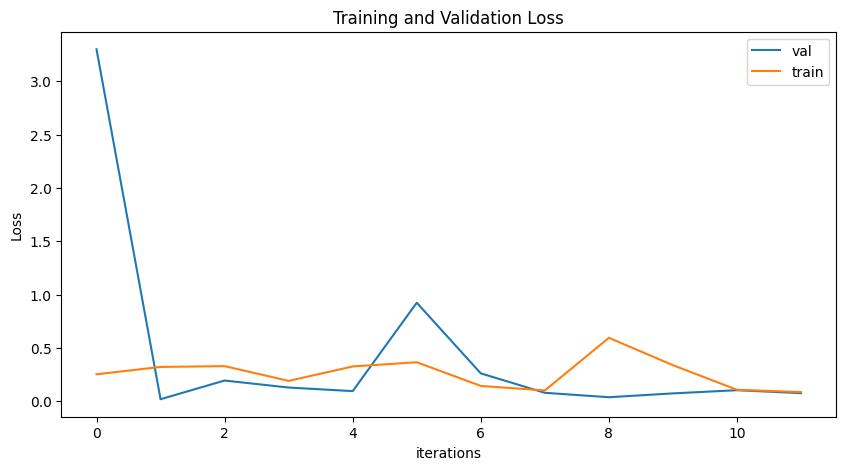

In [16]:
# model saving
best_val_loss = math.inf
#if the results are not enhanced after 10 epochs 
#training will be stopped and the model with the lowest val loss is saved

early_stopping = collections.deque(maxlen=int(10))
model_save_dir='/content/drive/MyDrive/saved_weights'
os.makedirs('/content/drive/MyDrive/saved_weights', exist_ok=True)
val_losses = []
train_losses = []
for epoch in range(1, params["epochs"] + 1):
    
    
    train_loss, train_accuracy = train(train_loader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(val_loader, model, criterion, epoch, params)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())


    # save if better on val_loss
    if val_loss < best_val_loss:
        model_save_path = os.path.join(model_save_dir, model_save_name + "_best.pt")
        best_val_loss = val_loss

        save_dict = {
            "state_dict": model.state_dict(),
            "epoch": epoch,
            "optimizer_state_dict": optimizer.state_dict()
            }
        torch.save(save_dict, model_save_path)
        
    early_stopping.append(val_loss.cpu().numpy())
    if len(early_stopping) >= early_stopping.maxlen:
        # if all elements in list are higher than best_val_loss
        if all(np.array(early_stopping)> best_val_loss.cpu().numpy()):
            model_save_path = os.path.join(model_save_dir, model_save_name + "_e{}".format(epoch) + ".pt")
            
            save_dict = {
                "state_dict": model.state_dict(),
                "epoch": epoch,
                "optimizer_state_dict": optimizer.state_dict()
                }
            torch.save(save_dict, model_save_path)

            break
        else:
            index_max = np.argmin(np.array(early_stopping))
#plot val loss and train loss
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [17]:
#test dataset
class FieldsVsRoadsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.Resize(250,300),
        A.CenterCrop(height=250, width=250),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_images_filepaths = sorted([os.path.join('/content/drive/MyDrive/dataset/test_images', f) for f in os.listdir('/content/drive/MyDrive/dataset/test_images')])
test_dataset = FieldsVsRoadsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False)

In [18]:
#use the best model for test
checkpoint = torch.load(model_save_dir+'/'+model_save_name+'_best.pt', map_location=params["device"]) #replace it with the path of the weights file
print(model_save_dir+'/'+model_save_name+'_best.pt')
model.load_state_dict(checkpoint["state_dict"])
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        output = output.view(output.shape[0], output.shape[1:].numel())
        output = classifier(output)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predicted_labels += ["Field" if is_field else "Road" for is_field in predictions]

/content/drive/MyDrive/saved_weights/exp10_best.pt


In [19]:
#show images with the lables
def display_image_grid(images_filepaths, predicted_labels=(), cols=4):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        predicted_label = predicted_labels[i] 
        color = "green" 
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

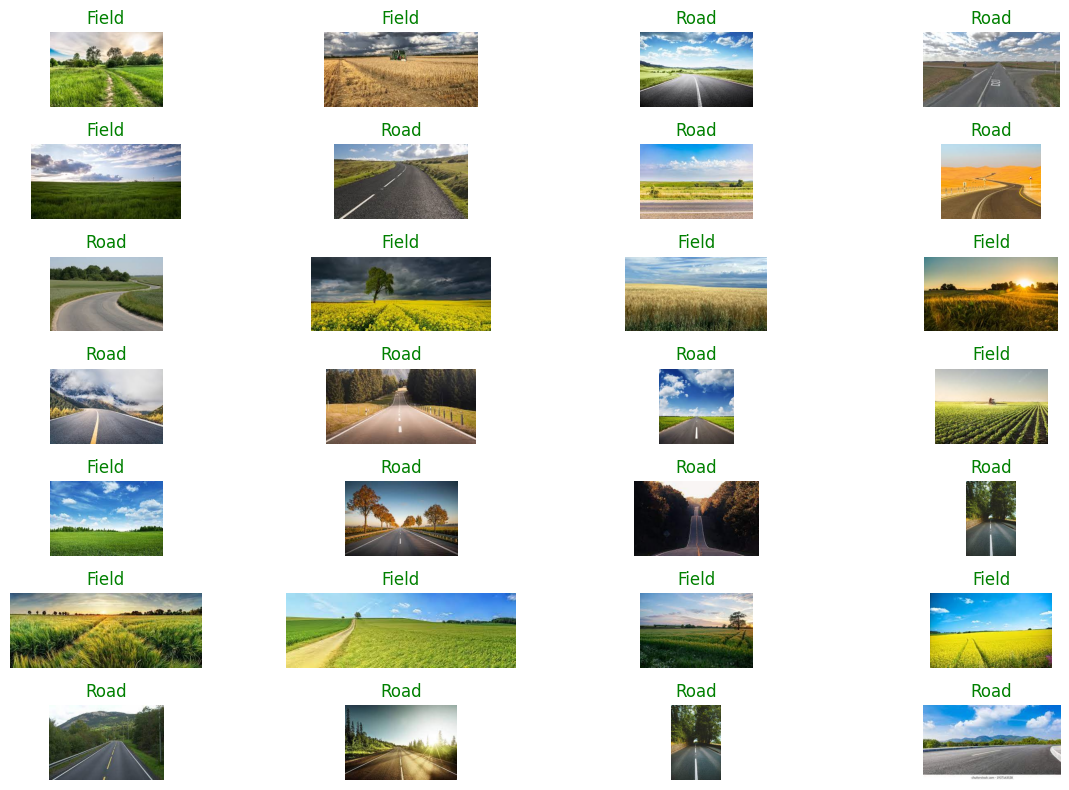

In [20]:
#show images with the predicted labels
display_image_grid(test_images_filepaths, predicted_labels)